![Image of Phoenix from Mountain Trail](https://github.com/bit-kitty/Coursera_Capstone/blob/master/ProjectData/images/KfBjNBvg.png?raw=true "Title") 

<h1 align=center><font size = 5>Coursera Capstone: The Battle of Neighborhoods in Phoenix</font></h1>
    
***

## Table of contents
* [Introduction](#introduction)
* [Problem Statement](#problem)
* [Data Description](#data)
* [Methodology](#methodology)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)
* [References](#references)

## Introduction <a name="introduction"></a>

Based on Wikipedia (https://en.wikipedia.org/wiki/Phoenix_metropolitan_area) and an article published in 2017 on AZ Central (https://www.azcentral.com/story/news/local/phoenix/2017/06/11/phoenix-nation-5th-largest-but-real-city/369917001/), Phoenix is one of the fastest growing metro areas within recent years and earned “two national distinctions with the U.S. Census Bureau numbers released Thursday [June 8, 2017]: Fifth-largest city and fastest-growing city.” However, due to its vast land mass within the [Metropolitan Statistical Area (MSA)](https://en.wikipedia.org/wiki/Metropolitan_area) boundaries, this got some thinking it to be rather atypical of a “true city,” like New York City. Key neighborhoods being miles apart don’t fit together well for people seeking a traditional sense of one big city. Having been in the area a short while, I find that the uniqueness of the area is very much appreciated in recent urban developments that have injected pieces of the real city in many neighborhoods surrounding the urban core.  This adds a different kind of urban flavor that takes a typical city adventure beyond a congested concrete jungle.

## Problem Statement <a name="problem"></a>

If the types of opinions described above remains pervasive, it may discourage some city seekers like new families and young professionals to dismiss the opportunities that lies within Arizona. One way to help new prospects better appreciate the area is to explore the various neighborhoods with geolocation data from Foursquare and supplemental local datapoints to understand the composition of top activities, popular venues, and businesses within key neighborhoods. We can then compare these areas to those within a big city like New York City for context. With growth, comes economic development and increased business opportunities. Any similarities/differences found during the exploration could be leveraged to help identify potential pockets of opportunities. Let's see what the data can tell us during this data exploration exercise.

## Data Description <a name="data"></a>

### *Objective*
* Compare/Contrast Phoenix's mix of popular venues focusing on Maricopa county versus those of a more established city, NYC's Manhattan borough (county equivalent).
* Based on differences, are there opportunities to leverage with localized business statistics and demo overlays for Phoenix

### *Sources*

* Foursquare Geolocation Datasets will be used to pull sample sets of top venues within the radius of the main metro areas. Categories of these venues will be used to cluster like activities and provide some contextual understanding within each neighborhood based on matches to the dataset with neighborhoods and their identified lat/long coordinates.
    * Phoenix (County: Maricopa)
    * New York City (Borough: Manhattan)  


* US State-County Latitutude/Longitude Dataset will provide the set of county zip codes along with to their lat/long coordinates that are needed to match to the Foursquare data.  


* Supplemental manual neighborhood identification lookups will provide name identification of Phoenix neighborhoods since a set list is not readily available online. Any additional local statistics if pertinent to the analysis may be included from Phoenix local government sites.
    * US Zip Code lookups for neighborhood names
    * Local Demographics Data  


* Census.gov will provide some national census related business statistics at the zip code level that may be pertinent to the evaluation exercise.
    * Business Statistics


* Given the shorten timeframe to turn around this analysis, supplemental location intelligence produced by Esri's (an expert in geographic science and the builder of ArcGIS, a powerful mapping and spatial analytics software) will be used to fill in characteristics about certain neighborhood segments within this study.
    * Esri's Tapestry Segmentation provides community lifestyle and demographic information

## Methodology <a name="methodology"></a>

GitHub will be used as the main collaborative repository with a web based graphical interface to host the files for this project. The majority of the processing will be conducted from a Python notebook on the IBM Watson platform. The base geolocation files will be built off of publicly available neighborhood latitude/longitude for each area. A simple clustering exercise employing K-means algorithms will first be conducted on Foursquare social networking data to compare top activities within Phoenix versus those within Manhattan for observations of basic behavior differences. Key points of differentiation from Manhattan will be leveraged to further build out segmentation for the Phoenix area to help identify pockets of potential opportunity within like neighborhoods with added demographics similarities.

### *Pre Processing and EDA*

#### 1. Start by prepping the environment for data wrangling and exploratory data analysis.


In [45]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import zipfile

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.datasets import load_iris
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
folium                    0.5.0                      py_0    conda-forge
Libraries imported.


#### 2. Next, retrieve the data to set up the datasets for a) Manhattan in NYC and b) Maricopa on Phoenix to explore. Starting off with Manhattan as the basis.

##### 2a) Referencing a previously employed data source during earlier lessons, let's download NYC Manhattan neighborhoods for comparison.

In [46]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    neighborhoods_data = newyork_data['features']
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
nyc_neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    nyc_neighborhoods = nyc_neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
print(nyc_neighborhoods.head())

print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(nyc_neighborhoods['Borough'].unique()),
        nyc_neighborhoods.shape[0]
    )
)

manhattan_data = nyc_neighborhoods[nyc_neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
print(manhattan_data.shape)
manhattan_data.head()

Data downloaded!
  Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585
The dataframe has 5 boroughs and 306 neighborhoods.
(40, 4)


,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [47]:
# Retrieve geographical coordinates of Manhattan using Nominatim: Manhattan Borough/County LL: 40.7900869, -73.9598295

address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="nyc_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7900869, -73.9598295.


##### The map for NYC shows the neighborhoods within the Manhattan borough as very tightly situated.

In [48]:
# Create a map of Manhattan using the latitude and longitude values for the neighborhoods in the borough; boroughs are equivalent to counties. 

map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

##### Let's use the Foursquare API to help explore and segment the area pulling current popular venues as of mid February 2019.

In [49]:
# The code was removed by Watson Studio for sharing.

##### For this, we use a radius of ~800 meters to cover a radius of ~.5 miles to grab Foursquare data for fuller coverage of as close to 100 venues per neighborhood to explore for Manhattan.

In [9]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

def getNearbyVenues(names, latitudes, longitudes, radius=800):  # retrieve as close to 100 venues per neighborhood as possible
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
# return the list of neighborhoods retrieved
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


##### Track counts of the venues received for Manhattan and it's neighborhoods.

In [50]:
print("Total for Manhattan:", manhattan_venues.shape)
manhattan_venues.head()

Total for Manhattan: (3890, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Sam's Pizza,40.879435,-73.905859,Pizza Place
4,Marble Hill,40.876551,-73.91066,Loeser's Delicatessen,40.879242,-73.905471,Sandwich Place


In [11]:
# Total venues by neighboorhood.
manhattan_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,100,100,100,100,100,100
Carnegie Hill,100,100,100,100,100,100
Central Harlem,100,100,100,100,100,100
Chelsea,100,100,100,100,100,100
Chinatown,100,100,100,100,100,100
Civic Center,100,100,100,100,100,100
Clinton,100,100,100,100,100,100
East Harlem,100,100,100,100,100,100
East Village,100,100,100,100,100,100


##### How many distinct categories of venues are there for Manhattan?

In [12]:
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 326 uniques categories.


In [13]:
# one hot encoding to tranpose distinct categories to columns
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

cols = manhattan_onehot.columns.tolist()
cols.insert(0, cols.pop(cols.index('Neighborhood')))
manhattan_onehot = manhattan_onehot.reindex(columns= cols)

print('New dataframe size:  ',manhattan_onehot.shape)
manhattan_onehot.head()

New dataframe size:   (3890, 327)


,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Cafeteria,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Duty-free Shop,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Hunan Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Social Club,Soup Place,South American Restaurant,South India

##### What are the average occurrences of these venues for all of Manhattan and by neighborhood?

In [14]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
print(manhattan_grouped.shape) 

manhattan_avgcat = manhattan_onehot.mean()

manhattan_avgcat =pd.Series.to_frame(manhattan_avgcat)
manhattan_avgcat.reset_index(inplace = True)

manhattan_avgcat.columns =['Venue Category','Manhattan Avg']
manhattan_avgtopcat = manhattan_avgcat.sort_values(by='Manhattan Avg', ascending = False) #, axis = 0,  inplace = False)
manhattan_avgtopcat # percent of occurrence within Manhattan


(40, 327)


,Venue Category,Manhattan Avg
69,Coffee Shop,0.040874
161,Italian Restaurant,0.038560
232,Pizza Place,0.025964
3,American Restaurant,0.023393
21,Bakery,0.021851
218,Park,0.021594
54,Café,0.020308
188,Mexican Restaurant,0.019537
135,Gym,0.018509
152,Hotel,0.017481


In [15]:
manhattan_grouped

,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Cafeteria,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Duty-free Shop,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Hunan Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Social Club,Soup Place,South American Restaurant,South India

##### List top venue types within neighborhoods.

In [16]:
num_top_venues = 5

for hood in manhattan_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Battery Park City----
         venue  freq
0         Park  0.09
1  Coffee Shop  0.08
2        Hotel  0.04
3        Plaza  0.03
4          Gym  0.03


----Carnegie Hill----
         venue  freq
0  Pizza Place  0.07
1         Café  0.05
2          Gym  0.04
3  Coffee Shop  0.04
4  Yoga Studio  0.03


----Central Harlem----
                             venue  freq
0               African Restaurant  0.04
1                      Coffee Shop  0.04
2                              Gym  0.03
3                    Deli / Bodega  0.03
4  Southern / Soul Food Restaurant  0.03


----Chelsea----
                 venue  freq
0          Coffee Shop  0.07
1  American Restaurant  0.04
2               Bakery  0.04
3   Italian Restaurant  0.04
4          Art Gallery  0.04


----Chinatown----
                 venue  freq
0   Chinese Restaurant  0.08
1       Ice Cream Shop  0.05
2         Cocktail Bar  0.05
3               Bakery  0.04
4  American Restaurant  0.04


----Civic Center----
                  

In [18]:
# to place data into dataframe
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [19]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
manhattan_venues_sorted = pd.DataFrame(columns=columns)
manhattan_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    manhattan_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

manhattan_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Coffee Shop,Hotel,Department Store,Plaza,Gym,Memorial Site,Grocery Store,Food Court,Shopping Mall
1,Carnegie Hill,Pizza Place,Café,Gym,Coffee Shop,Yoga Studio,Bookstore,Art Museum,Bakery,Spa,Wine Shop
2,Central Harlem,African Restaurant,Coffee Shop,Deli / Bodega,Gym,Southern / Soul Food Restaurant,Cosmetics Shop,Theater,French Restaurant,Pizza Place,Sushi Restaurant
3,Chelsea,Coffee Shop,Bakery,Italian Restaurant,American Restaurant,Ice Cream Shop,Art Gallery,Seafood Restaurant,Hotel,French Restaurant,Asian Restaurant
4,Chinatown,Chinese Restaurant,Cocktail Bar,Ice Cream Shop,Bakery,American Restaurant,Sandwich Place,Coffee Shop,Noodle House,Spa,Malay Restaurant


### 3. Use unsupervised learning by running K-means algorithm to cluster the Foursquare neighborhood activities and derive common themes about popular venue categories.

##### 3a. Cluster Manhattan's neighborhood venues to see if any segments make sense for interpretation.
Since the data to be clustered are unlabeled, first objective here is to determine the best number of clusters or 'k' to kick off the K-means model. The elbow method and silhouette scores will be used to help pick the best 'k', but these are not fool proof methods especially if the data points are fairly homogenous or doesn't cluster well into distinct groups. Often times, business context will override specifications.

   cluster_errors  num_clusters
0        0.565403             1
1        0.505203             2
2        0.472300             3
3        0.444997             4
4        0.424605             5
5        0.407072             6
6        0.382033             7
7        0.352550             8
8        0.336835             9


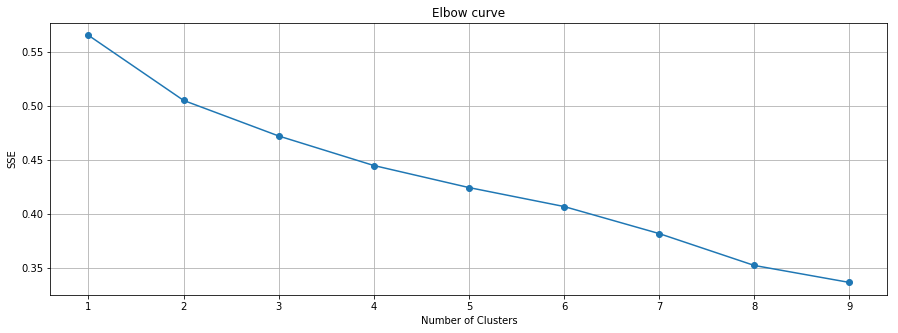

In [26]:
# Using the elbow method to help determine cluster size gives a very week indication of k=2.

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

X2 = manhattan_grouped_clustering
distortions = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=10) #, max_iter=1000)
    kmeans.fit(X2)
    distortions.append(kmeans.inertia_) # cluster errors

clusters_df2 = pd.DataFrame( { "num_clusters": range(1, 10), "cluster_errors": distortions } )
print(clusters_df2[0:10])

    
fig = plt.figure(figsize=(15, 5))
plt.plot( clusters_df2.num_clusters, clusters_df2.cluster_errors, marker = "o" )
plt.grid(True)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow curve')

plt.show()

Although they are weak indications, both the Elbow method and Silhouette scores appear to indicate 2 clusters as the best 'k'. 

In [28]:
# Let's force 2 clusters to explore and see if they make sense.

k_clus2 = 10

for i in range(2, k_clus2):
    kmeans = KMeans(n_clusters=i, random_state=10).fit(manhattan_grouped_clustering)
    cluster_labels = kmeans.fit_predict(manhattan_grouped_clustering)
    
    silhouette_avg = silhouette_score(manhattan_grouped_clustering, cluster_labels)
    print("For n_clusters =", i,
          "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.087348726092
For n_clusters = 3 The average silhouette_score is : 0.0702145102123
For n_clusters = 4 The average silhouette_score is : 0.0582038721248
For n_clusters = 5 The average silhouette_score is : 0.0473515639142
For n_clusters = 6 The average silhouette_score is : 0.0536426826676
For n_clusters = 7 The average silhouette_score is : 0.0617964820109
For n_clusters = 8 The average silhouette_score is : 0.0696628835269
For n_clusters = 9 The average silhouette_score is : 0.0593525593866


In [29]:
# set number of clusters
k_clus2 = 2

# run k-means clustering
kmeans = KMeans(n_clusters=k_clus2, random_state=10).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
manhattan_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data #manhattan_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(manhattan_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() 

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,1,Pharmacy,Donut Shop,Pizza Place,Spanish Restaurant,Bar,Bank,Mexican Restaurant,Shoe Store,Café,Athletics & Sports
1,Manhattan,Chinatown,40.715618,-73.994279,1,Chinese Restaurant,Cocktail Bar,Ice Cream Shop,Bakery,American Restaurant,Sandwich Place,Coffee Shop,Noodle House,Spa,Malay Restaurant
2,Manhattan,Washington Heights,40.851903,-73.936900,1,Pizza Place,Bakery,Latin American Restaurant,Mobile Phone Shop,Mexican Restaurant,Café,Park,Grocery Store,Deli / Bodega,Bar
3,Manhattan,Inwood,40.867684,-73.921210,1,Pizza Place,Mexican Restaurant,Café,Latin American Restaurant,Wine Bar,Deli / Bodega,Bakery,Spanish Restaurant,Restaurant,Lounge
4,Manhattan,Hamilton Heights,40.823604,-73.949688,1,Coffee Shop,Deli / Bodega,Café,Mexican Restaurant,Bar,Pizza Place,Sandwich Place,Chinese Restaurant,Yoga Studio,Park


In [51]:
# create map of clusters
map_clusters2 = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k_clus2)
ys = [i + x + (i*x)**2 for i in range(k_clus2)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters2)
       
map_clusters2

In fact, the segmented venue clusters do, to a certain degree, resemble the shapes of the Tapestry Segmentation developed by Esri. We will take advantage of some of the basic demoographics findings from Esri to help explain the additional nuances of our segments below.

As you can see, the plotted clusters above closely align with those of the Esri Tapestry segments in Manhattan for Laptops and Lattes (light blue blocks) and High Rise Renters (purple blocks). 

<table><tr>
<td> <img src="https://github.com/bit-kitty/Coursera_Capstone/blob/master/ProjectData/images/Esri-NY-segments.png?raw=true" width="425"> </td>
<td> <img src="https://github.com/bit-kitty/Coursera_Capstone/blob/master/ProjectData/images/Esri-LL.png?raw=true" width="400"> </td>
<td> <img src="https://github.com/bit-kitty/Coursera_Capstone/blob/master/ProjectData/images/Esri-HR.png?raw=true" width="400"> </td>
</tr></table>

To further understand the Foursquare clusters, let's continue to examine and note observations of descriminating factors.

In [39]:
# Resulting size of clusters.
print("Counts within Clusters 1 and 2:", manhattan_merged['Cluster Labels'].value_counts().to_dict())

Counts within Clusters 1 and 2: {0: 26, 1: 14}


In [ ]:
# add clustering labels to venue frequencies for segments

ll_1hot = manhattan_onehot
ll_1hot['LL'] = ll_1hot.Neighborhood.isin(manhattan_merged.Neighborhood).astype(np.int8)
ll_1hot

#ll_1hot = ll_1hot[ll_1hot['LL'] == 0]


#ll_avgcat = ll_1hot.mean()

#ll_avgcat =pd.Series.to_frame(ll_avgcat)
#ll_avgcat.reset_index(inplace = True)

#ll_avgcat.columns =['Venue Category','Cluster1 Avg']
#manhattan_avgtopcat = manhattan_avgcat.sort_values(by='Manhattan Avg', ascending = False) #, axis = 0,  inplace = False)
#manhattan_avgtopcat # percent of occurrence within Maricopa

#manhattan_merged.head() # check the last columns!  

In [40]:
# Cluster 1 (26 Red Dots): Matches best to Laptops and Lattes Segment

manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Upper East Side,Exhibit,Italian Restaurant,Bakery,Coffee Shop,Hotel,Gym / Fitness Center,Art Gallery,Yoga Studio,Spa,Sushi Restaurant
9,Yorkville,Italian Restaurant,Coffee Shop,Gym,Pizza Place,Bar,Japanese Restaurant,Mexican Restaurant,Wine Shop,Ice Cream Shop,Bagel Shop
10,Lenox Hill,Italian Restaurant,Sushi Restaurant,Gym / Fitness Center,Coffee Shop,Pizza Place,Burger Joint,Bakery,Sporting Goods Shop,Gym,Cocktail Bar
12,Upper West Side,Italian Restaurant,Coffee Shop,American Restaurant,Indian Restaurant,Wine Bar,Ice Cream Shop,Bakery,Bar,Burger Joint,Sushi Restaurant
13,Lincoln Square,Italian Restaurant,Theater,Gym / Fitness Center,French Restaurant,Gym,Concert Hall,Café,Indie Movie Theater,Opera House,Performing Arts Venue
14,Clinton,Theater,Italian Restaurant,Wine Shop,American Restaurant,Coffee Shop,Hotel,Gym / Fitness Center,Burger Joint,Bakery,Hotel Bar
15,Midtown,Coffee Shop,Theater,Hotel,Japanese Restaurant,Plaza,Cuban Restaurant,Steakhouse,Sushi Restaurant,Pizza Place,Bakery
16,Murray Hill,Coffee Shop,Gym / Fitness Center,Hotel,Japanese Restaurant,American Restaurant,Gym,Cocktail Bar,Italian Restaurant,Burger Joint,Sandwich Place
17,Chelsea,Coffee Shop,Bakery,Italian Restaurant,American Restaurant,Ice Cream Shop,Art Gallery,Seafood Restaurant,Hotel,French Restaurant,Asian Restaurant
18,Greenwich Village,Italian Restaurant,Clothing Store,Coffee Shop,Sushi Restaurant,Mediterranean Restaurant,Café,Seafood Restaurant,Ice Cream Shop,Yoga Studio,American Restaurant


In [41]:
# Cluster 2 (14 Purple Dots): 
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marble Hill,Pharmacy,Donut Shop,Pizza Place,Spanish Restaurant,Bar,Bank,Mexican Restaurant,Shoe Store,Café,Athletics & Sports
1,Chinatown,Chinese Restaurant,Cocktail Bar,Ice Cream Shop,Bakery,American Restaurant,Sandwich Place,Coffee Shop,Noodle House,Spa,Malay Restaurant
2,Washington Heights,Pizza Place,Bakery,Latin American Restaurant,Mobile Phone Shop,Mexican Restaurant,Café,Park,Grocery Store,Deli / Bodega,Bar
3,Inwood,Pizza Place,Mexican Restaurant,Café,Latin American Restaurant,Wine Bar,Deli / Bodega,Bakery,Spanish Restaurant,Restaurant,Lounge
4,Hamilton Heights,Coffee Shop,Deli / Bodega,Café,Mexican Restaurant,Bar,Pizza Place,Sandwich Place,Chinese Restaurant,Yoga Studio,Park
5,Manhattanville,Park,Chinese Restaurant,Italian Restaurant,Mexican Restaurant,Sandwich Place,Indian Restaurant,Deli / Bodega,Coffee Shop,Seafood Restaurant,Donut Shop
6,Central Harlem,African Restaurant,Coffee Shop,Deli / Bodega,Gym,Southern / Soul Food Restaurant,Cosmetics Shop,Theater,French Restaurant,Pizza Place,Sushi Restaurant
7,East Harlem,Mexican Restaurant,Bakery,Pizza Place,Thai Restaurant,Latin American Restaurant,Deli / Bodega,Plaza,Café,Spanish Restaurant,Cocktail Bar
11,Roosevelt Island,Park,Japanese Restaurant,Gym,Greek Restaurant,Baseball Field,Sushi Restaurant,Pool,Deli / Bodega,Yoga Studio,Residential Building (Apartment / Condo)
19,East Village,Coffee Shop,Cocktail Bar,Pizza Place,Wine Bar,Ice Cream Shop,Bar,Seafood Restaurant,Juice Bar,Vegetarian / Vegan Restaurant,Japanese Restaurant


In [71]:
# Download zip code latitude and longitude from geonames.org to isolate for Maricopa County in Phoenix
url = 'http://download.geonames.org/export/zip/US.zip'
content = requests.get(url)

# unzip the content
from io import BytesIO
from zipfile import ZipFile
f = ZipFile(BytesIO(content.content))
print("File in zip: ", f.namelist())

df1 = pd.read_csv(f.open('US.txt'), delimiter="\t", low_memory=False) #, skiprows=[0])
df1.columns = ['country_code', 
               'postal_code', 
               'place_name', 
               'state', 
               'state_code', 
               'county',
               'county_cd', 
               'admin_name3', 
               'admin_code3', 
               'latitude', 
               'longitude', 
               'accuracy']

# keep Maricopa County Zipcodes
df1 = df1.iloc[:, [1, 2, 4, 5, 9,10]]
df1 = df1[(df1['county'] == 'Maricopa')] 
print("File dimensions:", df1.shape)
print(df1.head())


File in zip:  ['readme.txt', 'US.txt']
File dimensions: (197, 6)
      postal_code place_name state_code    county  latitude  longitude
1906        85001    Phoenix         AZ  Maricopa   33.4484  -112.0740
1907        85002    Phoenix         AZ  Maricopa   33.4484  -112.0740
1908        85003    Phoenix         AZ  Maricopa   33.4511  -112.0774
1909        85004    Phoenix         AZ  Maricopa   33.4557  -112.0686
1910        85005    Phoenix         AZ  Maricopa   33.4484  -112.0740


In [72]:
# read in manually compiled Phoenix Maricopa neighborhood assignments and merge to lat/long 
path = path='https://raw.githubusercontent.com/bit-kitty/Coursera_Capstone/master/ProjectData/maricopa_neighborhoodzip.csv'
df2 = pd.read_csv(path)
print(df2.head())

df1['neighborhood'] = df1['postal_code'].map(df2.drop_duplicates('postal_code').set_index('postal_code')['neighborhood'])
mari_neighborhoods = df1.dropna()
mari_neighborhoods = mari_neighborhoods.reset_index(drop=True)

print(mari_neighborhoods.shape)
#print(mari_neighborhoods.head())

# aggregate neighborhood lat/longs: approximately 63 identified across the metro area
mari_hood_agg = mari_neighborhoods.groupby(['neighborhood'])['latitude','longitude'].mean()
mari_hood_agg['county']='Maricopa'
mari_hood_agg=mari_hood_agg.reset_index(drop=False)
cols = mari_hood_agg.columns.tolist()
cols.insert(0, cols.pop(cols.index('county')))
mari_hood_agg=mari_hood_agg.reindex(columns=cols)
print(mari_hood_agg.shape)
mari_hood_agg

   postal_code             neighborhood  total_pop  pop_density  \
0        85003  Willo Historic District    11936.0       6183.0   
1        85004            Cooper Square     6199.0       3069.0   
2        85006         Downtown Phoenix    28021.0       7127.0   
3        85007         Downtown Phoenix    15183.0       3399.0   
4        85008           Camelback East    60792.0       6085.0   

   diversity_index  avg_hh_income  avg_hh_sz  median_age  
0             78.6        66405.0       1.78        39.2  
1             78.8        63828.0       1.72        32.3  
2             84.8        41656.0       2.97        31.0  
3             86.2        53639.0       2.68        33.2  
4             85.8        49033.0       2.82        28.7  
(138, 7)
(63, 4)


,county,neighborhood,latitude,longitude
0,Maricopa,Ahwatukee Foothills,33.315767,-112.061267
1,Maricopa,Alhambra,33.510800,-112.102900
2,Maricopa,Arcadia,33.494700,-111.952500
3,Maricopa,Arlington,33.313300,-112.789100
4,Maricopa,Avondale,33.454900,-112.326550
5,Maricopa,Barrel District,33.580900,-112.174950
6,Maricopa,Biltmore,33.502100,-112.030500
7,Maricopa,Brentwood-Cavalier,33.391700,-111.924900
8,Maricopa,Buckeye,33.419150,-112.531250
9,Maricopa,Camelback East,33.454433,-112.048800


In [73]:
# Maricopa County LL:  33.34883, -112.49123
## Let's get geographical coordinates of Maricopa County
address = 'Maricopa County, AZ'

geolocator = Nominatim(user_agent="phx_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Maricopa are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Maricopa are 33.34883, -112.49123.


#### Notice how wide spread the neighborhoods are within the Maricopa County of Phoenix.

In [74]:
# create map of Maricopa County using latitude and longitude values

map_maricopa = folium.Map(location=[latitude, longitude], zoom_start=9)

# add markers to map
for lat, lng, label in zip(mari_hood_agg['latitude'], mari_hood_agg['longitude'], mari_hood_agg['neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='cyan',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_maricopa)  
    
map_maricopa

In [76]:
mari_hood_agg.loc[0, 'neighborhood']

'Ahwatukee Foothills'

### Now, let's get the top 100 venues that are within the area limit, ~2-3 miles since Phoenix metro has a much larger land size.

In [77]:
neighborhood_latitude = mari_hood_agg.loc[0, 'latitude'] # neighborhood latitude value
neighborhood_longitude = mari_hood_agg.loc[0, 'longitude'] # neighborhood longitude value

neighborhood_name = mari_hood_agg.loc[0, 'neighborhood'] # neighborhood name

print('latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

latitude and longitude values of Ahwatukee Foothills are 33.31576666666667, -112.06126666666667.


In [78]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 5000 # expand radius due to the land mass being greater within Phoenix
api_url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
# url
results = requests.get(api_url).json()

In [79]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [80]:
# clean and structure into dataframe
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))
nearby_venues.head()

49 venues were returned by Foursquare.


,name,categories,lat,lng
0,Telegraph Pass Trailhead,Trail,33.317698,-112.066606
1,Desert Foothills Park,Park,33.305099,-112.059412
2,Yoasis Self-Serve Frozen Yogurt,Frozen Yogurt Shop,33.306392,-112.055019
3,YMCA,Gym,33.296694,-112.059854
4,Dobbins Lookout,Scenic Lookout,33.345169,-112.058435


In [81]:
# Explore the neighborhoods in Maricopa
## open up radius due to larger land areas within these zips to cover ~ 2-3miles

def getNearbyVenues(names, latitudes, longitudes, radius=5000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

maricopa_venues = getNearbyVenues(names=mari_hood_agg['neighborhood'],
                                   latitudes=mari_hood_agg['latitude'],
                                   longitudes=mari_hood_agg['longitude']
                                  )

Ahwatukee Foothills
Alhambra
Arcadia
Arlington
Avondale
Barrel District
Biltmore
Brentwood-Cavalier
Buckeye
Camelback East
Cave Creek
Central City
Chandler
Cheery Lynn Historic District
Cholla District
Cooper Square
DC Ranch Scottsdale
Deer Valley
Desert Foothills
Desert View
Downtown Phoenix
El Mirage
Estrella
Fort Mcdowell
Gila Bend
Gilbert
Glendale
Goodyear
Granite Mountain
Higley
Horizons
Indian Bend
Laveen
Maryvale
McDowell Mountain Preserve
Mesa
Moon Valley
Morristown
New River
North Mountain
North Tempe
Ocotillo District
Palo Verde
Paradise Valley
Peoria
Queen Creek
Rio Verde
Sahuaro District
Scottsdale
South Mountain
South Scottsdale
Sun City
Sun City West
Sunnyslope
Surprise
Tempe
Tonopah
Waddell
Wickenburg
Willo Historic District
Wittmann
Youngtown 
Yucca District Glendale


#### Total venues retrieved for Maricopa and the neighborhoods within:

In [82]:
print(maricopa_venues.shape)
maricopa_venues.head()

(4837, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ahwatukee Foothills,33.315767,-112.061267,Telegraph Pass Trailhead,33.317698,-112.066606,Trail
1,Ahwatukee Foothills,33.315767,-112.061267,Desert Foothills Park,33.305099,-112.059412,Park
2,Ahwatukee Foothills,33.315767,-112.061267,Yoasis Self-Serve Frozen Yogurt,33.306392,-112.055019,Frozen Yogurt Shop
3,Ahwatukee Foothills,33.315767,-112.061267,YMCA,33.296694,-112.059854,Gym
4,Ahwatukee Foothills,33.315767,-112.061267,Dobbins Lookout,33.345169,-112.058435,Scenic Lookout


In [83]:
# remove 11 neighborhoods with low venue counts which are mostly neighborhoods along the outerskirts of the county boundaries.

# Get the count of each value
value_counts = maricopa_venues['Neighborhood'].value_counts()

# Select the neighborhood where the count is less than 48
remove = value_counts[value_counts < 48].index
maricopa_venues = maricopa_venues[~maricopa_venues.Neighborhood.isin(remove)]
print(maricopa_venues.shape)
maricopa_venues.groupby('Neighborhood').count()

(4728, 7)


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Ahwatukee Foothills,49,49,49,49,49,49
Alhambra,100,100,100,100,100,100
Arcadia,100,100,100,100,100,100
Avondale,100,100,100,100,100,100
Barrel District,100,100,100,100,100,100
Biltmore,100,100,100,100,100,100
Brentwood-Cavalier,100,100,100,100,100,100
Buckeye,49,49,49,49,49,49
Camelback East,100,100,100,100,100,100


#### How many distinct categories of venues was returned?

In [85]:
print('There are {} uniques categories.'.format(len(maricopa_venues['Venue Category'].unique())))

There are 286 uniques categories.


#### Recode the dataset to analyze each neighborhood.

In [86]:
# one hot encoding
maricopa_onehot = pd.get_dummies(maricopa_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
maricopa_onehot['Neighborhood'] = maricopa_venues['Neighborhood'] 

cols = maricopa_onehot.columns.tolist()
cols.insert(0, cols.pop(cols.index('Neighborhood')))
maricopa_onehot = maricopa_onehot.reindex(columns= cols)

print('New dataframe size:  ',maricopa_onehot.shape)
maricopa_onehot.head()

New dataframe size:   (4728, 286)


,Neighborhood,ATM,Accessories Store,Adult Boutique,Advertising Agency,African Restaurant,Airport,Airport Service,Alternative Healer,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Butcher,Café,Cajun / Creole Restaurant,Campground,Candy Store,Cantonese Restaurant,Capitol Building,Caribbean Restaurant,Casino,Castle,Chinese Restaurant,Church,Churrascaria,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Stadium,Comedy Club,Comfort Food Restaurant,Comic Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Hunting Supply,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Mongolian Restaurant,Motel,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,New American Restaurant,Night Market,Nightclub,Noodle House,Office,Opera House,Optical Shop,Outdoor Sculpture,Outdoor Supply Store,Outlet Mall,Outlet Store,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Piercing Parlor,Pizza Place,Playground,Plaza,Pool,Pool Hall,Professional & Other Places,Pub,RV Park,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stables,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tanning Salon,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Track,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Wi

#### What are the average occurences of these top venue categories by neighborhood and for all of Maricopa?

In [87]:
maricopa_grouped = maricopa_onehot.groupby('Neighborhood').mean().reset_index()
print(maricopa_grouped.shape) 

# print('Descriptive Statistics for Maricopa Top Venues: ', maricopa_onehot.describe(include='all'))
# retrieve top occurrences of venue categories across area
maricopa_avgcat = maricopa_onehot.mean()

maricopa_avgcat =pd.Series.to_frame(maricopa_avgcat)
maricopa_avgcat.reset_index(inplace = True)

maricopa_avgcat.columns =['Venue Category','Maricopa Avg']
maricopa_avgtopcat = maricopa_avgcat.sort_values(by='Maricopa Avg', ascending = False) #, axis = 0,  inplace = False)
maricopa_avgtopcat

(50, 286)


,Venue Category,Maricopa Avg
211,Pizza Place,0.057953
175,Mexican Restaurant,0.056684
66,Coffee Shop,0.049492
8,American Restaurant,0.033206
230,Sandwich Place,0.030457
97,Fast Food Restaurant,0.028976
125,Grocery Store,0.027919
47,Burger Joint,0.022843
72,Convenience Store,0.022208
155,Italian Restaurant,0.020093


In [88]:
maricopa_grouped.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,Advertising Agency,African Restaurant,Airport,Airport Service,Alternative Healer,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Butcher,Café,Cajun / Creole Restaurant,Campground,Candy Store,Cantonese Restaurant,Capitol Building,Caribbean Restaurant,Casino,Castle,Chinese Restaurant,Church,Churrascaria,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Stadium,Comedy Club,Comfort Food Restaurant,Comic Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Hunting Supply,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Mongolian Restaurant,Motel,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,New American Restaurant,Night Market,Nightclub,Noodle House,Office,Opera House,Optical Shop,Outdoor Sculpture,Outdoor Supply Store,Outlet Mall,Outlet Store,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Piercing Parlor,Pizza Place,Playground,Plaza,Pool,Pool Hall,Professional & Other Places,Pub,RV Park,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stables,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tanning Salon,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Track,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Wi

In [89]:
# List top 5 occurring venues for each neighborhood.

num_top_venues = 5

for hood in maricopa_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = maricopa_grouped[maricopa_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Ahwatukee Foothills----
            venue  freq
0           Trail  0.24
1  Scenic Lookout  0.12
2            Park  0.06
3     Pizza Place  0.06
4     Golf Course  0.06


----Alhambra----
                venue  freq
0         Pizza Place  0.05
1  Mexican Restaurant  0.04
2         Coffee Shop  0.04
3   Convenience Store  0.03
4        Burger Joint  0.03


----Arcadia----
                     venue  freq
0      American Restaurant  0.07
1              Coffee Shop  0.06
2              Pizza Place  0.06
3                    Hotel  0.05
4  New American Restaurant  0.04


----Avondale----
                  venue  freq
0    Mexican Restaurant  0.09
1  Fast Food Restaurant  0.06
2           Pizza Place  0.05
3                   Gym  0.05
4           Coffee Shop  0.05


----Barrel District----
                venue  freq
0         Pizza Place  0.10
1  Mexican Restaurant  0.08
2         Coffee Shop  0.06
3      Sandwich Place  0.05
4       Grocery Store  0.04


----Biltmore----
             

In [110]:
# Itemize top 10 occurring venues for each neighborhood.

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
marihoods_venues_sorted = pd.DataFrame(columns=columns)
marihoods_venues_sorted['Neighborhood'] = maricopa_grouped['Neighborhood']

for ind in np.arange(maricopa_grouped.shape[0]):
    marihoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(maricopa_grouped.iloc[ind, :], num_top_venues)

marihoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ahwatukee Foothills,Trail,Scenic Lookout,Park,Golf Course,Pizza Place,Coffee Shop,Mountain,Gym,Frozen Yogurt Shop,Gas Station
1,Alhambra,Pizza Place,Coffee Shop,Mexican Restaurant,Gay Bar,Thai Restaurant,Fast Food Restaurant,American Restaurant,Burger Joint,Convenience Store,Hotel
2,Arcadia,American Restaurant,Coffee Shop,Pizza Place,Hotel,New American Restaurant,Mediterranean Restaurant,Bar,Café,Mexican Restaurant,Salon / Barbershop
3,Avondale,Mexican Restaurant,Fast Food Restaurant,Coffee Shop,Gym,Pizza Place,American Restaurant,Burger Joint,Asian Restaurant,Department Store,Japanese Restaurant
4,Barrel District,Pizza Place,Mexican Restaurant,Coffee Shop,Sandwich Place,Burger Joint,Grocery Store,Italian Restaurant,Gym,Vietnamese Restaurant,Fast Food Restaurant


   cluster_errors  num_clusters
0        0.771412             1
1        0.675960             2
2        0.589835             3
3        0.532293             4
4        0.502260             5
5        0.465215             6
6        0.439343             7
7        0.407010             8
8        0.381282             9


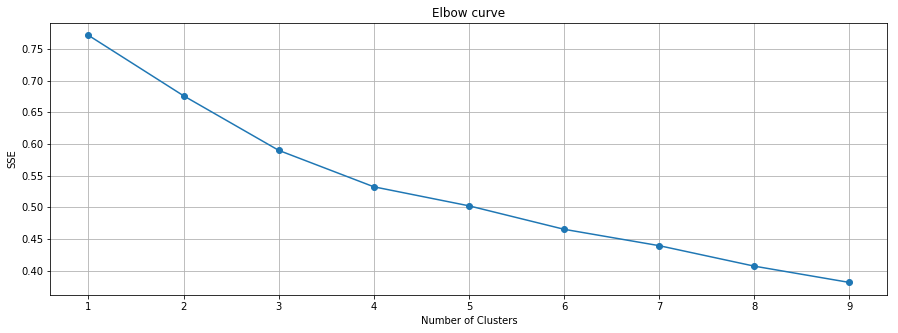

In [101]:
# Use unsupervised learning by running K-means algorithm to cluster the neighborhoods to derive common themes of venue categories. 
# k-Means is a partition-based clustering that produces sphere-like clusters because the clusters are shaped around the centroids. 
# However, there is an added step to pre-specify the number of clusters. This requires due diligence to pick the number of clusters.
# Often times, business context contributes to the clusters that best explain the most variances within the observed datapoints.


# Run elbow curve on data to determine best number of clusters that explain the most variance (score denotes the percentage of variance explained)
# The elbow method aids in finding the optimal value for k (#clusters) at the point of rapidly declining improvement.
# Use unsupervised learning by running K-means algorithm to cluster the neighborhoods to derive common themes of venue categories. 
# Here the elbow method is not very strong in clustering average occurrences of venue types across the region; it somewhat indicates k= 3 or 4.

maricopa_grouped_clustering = maricopa_grouped.drop('Neighborhood', 1)

X1 = maricopa_grouped_clustering

distortions = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=3, max_iter=500)
    kmeans.fit(X1)
    distortions.append(kmeans.inertia_) # cluster errors
    
clusters_df = pd.DataFrame( { "num_clusters": range(1, 10), "cluster_errors": distortions } )
print(clusters_df[0:10])

fig = plt.figure(figsize=(15, 5))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )
plt.grid(True)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow curve')

plt.show()


In [102]:
# Validating Ks with Silhouette method of interpretation seems to indicate best k= 3 or 4. 
# So let's test somewhere between 2-5 clusters and see what makes sense.

k_clus1 = 10

for i in range(2, k_clus1):
    kmeans = KMeans(n_clusters=i, random_state=3, max_iter=500).fit(maricopa_grouped_clustering)
    cluster_labels = kmeans.fit_predict(maricopa_grouped_clustering)


    silhouette_avg = silhouette_score(maricopa_grouped_clustering, cluster_labels)
    print("For n_clusters =", i,
          "The average silhouette_score is :", silhouette_avg)


For n_clusters = 2 The average silhouette_score is : 0.152710377073
For n_clusters = 3 The average silhouette_score is : 0.165341849934
For n_clusters = 4 The average silhouette_score is : 0.101163700494
For n_clusters = 5 The average silhouette_score is : 0.102222260013
For n_clusters = 6 The average silhouette_score is : 0.0885677394131
For n_clusters = 7 The average silhouette_score is : 0.0969763804407
For n_clusters = 8 The average silhouette_score is : 0.109356739018
For n_clusters = 9 The average silhouette_score is : 0.134857148939


In [111]:
# set number of clusters
k_clus1 = 4

# run k-means clustering
kmeans = KMeans(n_clusters=k_clus1, random_state=5, max_iter=1000).fit(maricopa_grouped_clustering) #, max_iter=1000

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:1] 

# add clustering labels
marihoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

maricopa_merged = mari_hood_agg # maricopa data

# merge maricopa grouped neighborhood with original data to add latitude/longitude for each neighborhood
maricopa_merged = maricopa_merged.join(marihoods_venues_sorted.set_index('Neighborhood'), on='neighborhood')
maricopa_merged.dropna(subset=['Cluster Labels'], inplace=True)
maricopa_merged.loc[:, 'Cluster Labels'] = maricopa_merged['Cluster Labels'].astype(int)
maricopa_merged.head() # check the last columns!  

,county,neighborhood,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Maricopa,Ahwatukee Foothills,33.315767,-112.061267,2,Trail,Scenic Lookout,Park,Golf Course,Pizza Place,Coffee Shop,Mountain,Gym,Frozen Yogurt Shop,Gas Station
1,Maricopa,Alhambra,33.510800,-112.102900,3,Pizza Place,Coffee Shop,Mexican Restaurant,Gay Bar,Thai Restaurant,Fast Food Restaurant,American Restaurant,Burger Joint,Convenience Store,Hotel
2,Maricopa,Arcadia,33.494700,-111.952500,3,American Restaurant,Coffee Shop,Pizza Place,Hotel,New American Restaurant,Mediterranean Restaurant,Bar,Café,Mexican Restaurant,Salon / Barbershop
4,Maricopa,Avondale,33.454900,-112.326550,1,Mexican Restaurant,Fast Food Restaurant,Coffee Shop,Gym,Pizza Place,American Restaurant,Burger Joint,Asian Restaurant,Department Store,Japanese Restaurant
5,Maricopa,Barrel District,33.580900,-112.174950,1,Pizza Place,Mexican Restaurant,Coffee Shop,Sandwich Place,Burger Joint,Grocery Store,Italian Restaurant,Gym,Vietnamese Restaurant,Fast Food Restaurant


In [112]:
# create map of clusters
import folium
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9)

# set color scheme for the clusters
x = np.arange(k_clus1)
ys = [i + x + (i*x)**2 for i in range(k_clus1)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(maricopa_merged['latitude'], maricopa_merged['longitude'], maricopa_merged['neighborhood'], maricopa_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [113]:
# Examine clusters. Note observations of descriminating factors. K=3 makes most sense given the neighborhood types clustering together.
print("Count within clusters:", maricopa_merged['Cluster Labels'].value_counts().to_dict())

# Cluster 1: Young and Restless "On-the-Go" Professionals
maricopa_merged.loc[maricopa_merged['Cluster Labels'] == 0, maricopa_merged.columns[[1] + list(range(5, maricopa_merged.shape[1]))]]

Count within clusters: {0: 9, 1: 28, 2: 1, 3: 12}


,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Buckeye,Fast Food Restaurant,Pizza Place,Wings Joint,Sandwich Place,Donut Shop,ATM,Cosmetics Shop,Shoe Store,Salon / Barbershop,RV Park
20,Downtown Phoenix,Mexican Restaurant,Sandwich Place,Convenience Store,Fast Food Restaurant,Burger Joint,Pizza Place,Chinese Restaurant,American Restaurant,Gas Station,Coffee Shop
21,El Mirage,Mexican Restaurant,Fast Food Restaurant,Coffee Shop,Grocery Store,American Restaurant,Pharmacy,Convenience Store,Pizza Place,Ice Cream Shop,Sandwich Place
22,Estrella,Convenience Store,Mexican Restaurant,Fast Food Restaurant,Gas Station,Sandwich Place,Pizza Place,Pharmacy,Grocery Store,Hotel,Discount Store
32,Laveen,Fast Food Restaurant,Pizza Place,Chinese Restaurant,Sandwich Place,Mexican Restaurant,Pharmacy,Bank,Coffee Shop,Discount Store,Shoe Store
33,Maryvale,Mexican Restaurant,Convenience Store,Sandwich Place,Fast Food Restaurant,Gas Station,Chinese Restaurant,Discount Store,Seafood Restaurant,Pizza Place,Pharmacy
41,Ocotillo District,Pizza Place,Mexican Restaurant,Sandwich Place,Discount Store,Pharmacy,Bar,Convenience Store,Chinese Restaurant,Fast Food Restaurant,Bank
51,Sun City,Pizza Place,Coffee Shop,Pharmacy,Fast Food Restaurant,American Restaurant,Mexican Restaurant,Convenience Store,Chinese Restaurant,Video Store,Rental Car Location
61,Youngtown,Fast Food Restaurant,Pizza Place,Pharmacy,Mexican Restaurant,Convenience Store,Discount Store,Video Store,Sandwich Place,Grocery Store,Coffee Shop


In [114]:
# Cluster 2: Multi Cultural Urban Quarters
maricopa_merged.loc[maricopa_merged['Cluster Labels'] == 1, maricopa_merged.columns[[1] + list(range(5, maricopa_merged.shape[1]))]]

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Avondale,Mexican Restaurant,Fast Food Restaurant,Coffee Shop,Gym,Pizza Place,American Restaurant,Burger Joint,Asian Restaurant,Department Store,Japanese Restaurant
5,Barrel District,Pizza Place,Mexican Restaurant,Coffee Shop,Sandwich Place,Burger Joint,Grocery Store,Italian Restaurant,Gym,Vietnamese Restaurant,Fast Food Restaurant
7,Brentwood-Cavalier,Coffee Shop,American Restaurant,Mexican Restaurant,Grocery Store,Sandwich Place,Liquor Store,Pizza Place,Donut Shop,Greek Restaurant,Breakfast Spot
12,Chandler,Mexican Restaurant,Coffee Shop,Fast Food Restaurant,Grocery Store,Bar,Gym,Chinese Restaurant,Hotel,Pizza Place,Italian Restaurant
14,Cholla District,Pizza Place,Coffee Shop,American Restaurant,Grocery Store,Italian Restaurant,Sandwich Place,Cosmetics Shop,Pet Store,Sports Bar,Bagel Shop
16,DC Ranch Scottsdale,Coffee Shop,Italian Restaurant,Sandwich Place,American Restaurant,Pizza Place,Grocery Store,Golf Course,Ice Cream Shop,Mexican Restaurant,Steakhouse
17,Deer Valley,Pizza Place,Mexican Restaurant,Sandwich Place,Coffee Shop,Convenience Store,Gym,Burger Joint,Pet Store,Grocery Store,Fast Food Restaurant
18,Desert Foothills,Coffee Shop,Pharmacy,Grocery Store,Golf Course,Sandwich Place,Mexican Restaurant,Spa,Gym / Fitness Center,Lake,Big Box Store
19,Desert View,Gym,Pizza Place,Fast Food Restaurant,Coffee Shop,Park,Pharmacy,Sandwich Place,Convenience Store,Video Store,Salon / Barbershop
23,Fort Mcdowell,Pizza Place,Mexican Restaurant,American Restaurant,Golf Course,Italian Restaurant,Pharmacy,Fast Food Restaurant,Trail,Coffee Shop,Casino


In [115]:
# Cluster 3: Metro Fusion Families
maricopa_merged.loc[maricopa_merged['Cluster Labels'] == 2, maricopa_merged.columns[[1] + list(range(5, maricopa_merged.shape[1]))]]

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ahwatukee Foothills,Trail,Scenic Lookout,Park,Golf Course,Pizza Place,Coffee Shop,Mountain,Gym,Frozen Yogurt Shop,Gas Station


In [116]:
# Cluster 4: xxx
maricopa_merged.loc[maricopa_merged['Cluster Labels'] == 3, maricopa_merged.columns[[1] + list(range(5, maricopa_merged.shape[1]))]]

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Alhambra,Pizza Place,Coffee Shop,Mexican Restaurant,Gay Bar,Thai Restaurant,Fast Food Restaurant,American Restaurant,Burger Joint,Convenience Store,Hotel
2,Arcadia,American Restaurant,Coffee Shop,Pizza Place,Hotel,New American Restaurant,Mediterranean Restaurant,Bar,Café,Mexican Restaurant,Salon / Barbershop
6,Biltmore,American Restaurant,Mexican Restaurant,Burger Joint,Pizza Place,Italian Restaurant,New American Restaurant,Coffee Shop,Vegetarian / Vegan Restaurant,Sandwich Place,Ice Cream Shop
9,Camelback East,Mexican Restaurant,Pizza Place,Coffee Shop,Bar,Art Gallery,Hotel,Theater,Pub,American Restaurant,Taco Place
11,Central City,Coffee Shop,Pizza Place,Mexican Restaurant,Bar,American Restaurant,Art Gallery,Music Venue,Pub,Hotel,Theater
13,Cheery Lynn Historic District,American Restaurant,Pizza Place,Ice Cream Shop,Mexican Restaurant,Sandwich Place,Burger Joint,Coffee Shop,Sushi Restaurant,Grocery Store,Food Truck
15,Cooper Square,Coffee Shop,Bar,Pizza Place,American Restaurant,Hotel,Art Gallery,Music Venue,Breakfast Spot,Theater,Pub
31,Indian Bend,Hotel,American Restaurant,Mexican Restaurant,Pizza Place,Steakhouse,Coffee Shop,Grocery Store,Restaurant,Gastropub,Sushi Restaurant
40,North Tempe,Pizza Place,Coffee Shop,Sandwich Place,Liquor Store,Burger Joint,American Restaurant,Bar,Mexican Restaurant,Brewery,Breakfast Spot
50,South Scottsdale,Coffee Shop,Mexican Restaurant,Pizza Place,Park,New American Restaurant,Seafood Restaurant,Hotel,Italian Restaurant,Café,Gastropub


In [70]:
# retrieve business and industry statistics from the Census.gov for further review of Maricopa County
# download zip code latitude and longitude from geonames.org to isolate for Maricopa County in Phoenix
url2 = 'https://census.gov/data/datasets/2016/econ/cbp/2016-cbp.html/zbp16detail.zip'
content = requests.get(url2)

# unzip the content
from io import BytesIO
from zipfile import ZipFile
f2 = ZipFile(BytesIO(content.content))
print("File in zip: ", f2.namelist())

df3 = pd.read_csv(f.open('zbp16detail.txt'), delimiter="\t", low_memory=False) #, skiprows=[0])
df3.columns = ['postal_code', 
               'naics', # Industry Code ('52----'= Finance and Insurance, '53----'= Real Estate and Rental and Leasing, 
                        #'54----'= Professional, Scientific, and Technical Services), '55----'= Management of Companies and Enterprises
               'n_estab', # Total Number of Establishments
               'N1_4', 
               'N5_9', 
               'N10_19',
               'N20_49', 
               'N50_99', 
               'N100_249', 
               'N250_499', 
               'N500_999', 
               'N1000']  # Number of Establishments: 1,000 or More Employee Size Class
print(df3.shape)
print(df3.head())

path = path='https://raw.githubusercontent.com/bit-kitty/Coursera_Capstone/master/ProjectData/maricopa_neighborhoodzip.csv'
df2 = pd.read_csv(path)
print(df2.head())

df1['neighborhood'] = df1['postal_code'].map(df2.drop_duplicates('postal_code').set_index('postal_code')['neighborhood'])
mari_neighborhoods = df1.dropna()
mari_neighborhoods = mari_neighborhoods.reset_index(drop=True)

print(mari_neighborhoods.shape)
#print(mari_neighborhoods.head())

# aggregate neighborhood lat/longs: approximately 64 identified across the metro area
mari_hood_agg = mari_neighborhoods.groupby(['neighborhood'])['latitude','longitude'].mean()
mari_hood_agg['county']='Maricopa'
mari_hood_agg=mari_hood_agg.reset_index(drop=False)
cols = mari_hood_agg.columns.tolist()
cols.insert(0, cols.pop(cols.index('county')))
mari_hood_agg=mari_hood_agg.reindex(columns=cols)
print(mari_hood_agg.shape)
mari_hood_agg

BadZipFile: File is not a zip file

## Results and Discussion <a name="results"></a>

## Conclusion <a name="conclusion"></a>

In [ ]:
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#mari_grpcl_scaled = scaler.fit_transform( maricopa_grouped_clustering )


#dendogram

import seaborn as sn
%matplotlib 

beer.columns # Index(['name', 'calories', 'sodium', 'alcohol', 'cost'], dtype='object')

X = beer[['calories', 'sodium', 'alcohol', 'cost']]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform( X )

cmap = sn.cubehelix_palette(as_cmap=True, rot=-.3, light=1)
sn.clustermap(X_scaled, cmap=cmap, linewidths=.5)